# Playing CartPole with Actor-Critic Method

We will implement the [Actor-Critic](https://papers.nips.cc/paper/1786-actor-critic-algorithms.pdf) method to train an agent on the [Open AI Gym](https://gym.openai.com/) CartPole-V0 environment.

### Actor-Critic methods

Actor-Critic methods are [temporal difference (TD) learning](https://en.wikipedia.org/wiki/Temporal_difference_learning) methods that represent the policy function independent of the value function.

A policy function (or policy) returns a probability distribution over actions that the agent can take based on the given state.
A value function determines the expected return for an agent starting at a given state and acting according to a particular policy forever after.

In the Actor-Critic method, the policy is referred to as the *actor* that proposes a set of possible actions given a state, and the estimated value function is referred to as the *critic*, which evaluates actions taken by the *actor* based on the given policy.

We will implement the *Actor* and *Critic* using one neural network with two outputs.


### CartPole-v0

In the [CartPole-v0 environment](https://gym.openai.com/envs/CartPole-v0), a pole is attached to a cart moving along a frictionless track.
The pole starts upright and the goal of the agent is to prevent it from falling over by applying a force of -1 or +1 to the cart.
A reward of +1 is given for every time step the pole remains upright.
An episode ends when (1) the pole is more than 15 degrees from vertical or (2) the cart moves more than 2.4 units from the center.

We consider to have *solved* the problem when the average total reward for the episode reaches 195 over 100 consecutive trials.

### Setup

In [1]:
%%bash
pip install gym
pip install pyglet

# Install additional packages for visualization
sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
pip install pyvirtualdisplay > /dev/null 2>&1
pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 18.7 MB/s eta 0:00:00


In [2]:
import collections
import gym
import numpy as np
import statistics
import tensorflow as tf
import tqdm

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from typing import Any, List, Sequence, Tuple

# Create the environment
env = gym.make("CartPole-v0")

# Set seed for experiment reproducibility
seed = 42
env.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

# Small epsilon value for stabilizing division operations
eps = np.finfo(np.float32).eps.item()

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

### Model

We model the *Actor* and *Critic* using one neural network that outputs the action probabilities and critic value, respectively.

During the forward pass, the model will take in the state as the input and will output both action probabilities and critic value $V$, which models the state-dependent [value function](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#value-functions). The goal is to train a model that chooses actions based on a policy $\pi$ that maximizes expected [return](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#reward-and-return).

In Carpole-v0, there are four values representing the state: cart position, cart-velocity, pole angle and pole velocity. The agent can take two actions to push the cart: push the cart left (0) or push the cart right (1).

In [3]:
class ActorCritic(tf.keras.Model):
  """Combined actor-critic network."""
  def __init__(
      self,
      num_actions: int,
      num_hidden_units: int):
    super().__init__()
    self.common = layers.Dense(num_hidden_units, activation="relu")
    self.actor = layers.Dense(num_actions)
    self.critic = layers.Dense(1)

  def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    x = self.common(inputs)
    return self.actor(x), self.critic(x)

Instantiate model:

In [4]:
num_actions = env.action_space.n  # 2
num_hidden_units = 128

model = ActorCritic(num_actions, num_hidden_units)

### Training

To train the agent, we will do the following:

1. Run the agent on the environment to collect training data per episode
2. Compute the expected return at each time step
3. Compute the loss for the combined actor-critic model
4. Compute gradients, update network parameters
5. Repeat 1-4 until success criterion is met or max episodes have been reached

### 1. Collecting Training Data

In order to train the actor-critic model in a supervised learning fashion, we require data. We do so by running the model in the environment.

We collect training data for each episode. Then at each time step, the model's forward pass will be run on the environment's state in order to generate action probabilities and the critic value based on the current policy parameterized by the model's weights.

The next action will be sampled from the action probabilities generated by the model, which would then be applied to the environment, causing the next state and reward to be generated.

In [5]:
# Wrap OpenAI Gym's `env.step` call as an operation in a TensorFlow function.
# This would allow it to be included in a callable TensorFlow graph.

def env_step(action: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  state, reward, done, _ = env.step(action)
  return (state.astype(np.float32),
          np.array(reward, np.int32),
          np.array(done, np.int32))

def tf_env_step(action: tf.Tensor) -> List[tf.Tensor]:
  return tf.numpy_function(env_step, [action],
                           [tf.float32, tf.int32, tf.int32])

In [6]:
def run_episode(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    max_steps: int) -> Tuple[tf.Tensor, tf.Tensor, tf.Tensor]:
  """Runs a single episode to collect training data."""

  action_probs = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  values = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
  rewards = tf.TensorArray(dtype=tf.int32, size=0, dynamic_size=True)

  initial_state_shape = initial_state.shape
  state = initial_state

  for t in tf.range(max_steps):
    # Convert state into a batched tensor (batch size = 1)
    state = tf.expand_dims(state, 0)

    # Run the model to get action probabilities and critic value
    action_logits_t, value = model(state)

    # Sample next action from the action probability distribution
    action = tf.random.categorical(action_logits_t, 1)[0, 0]
    action_probs_t = tf.nn.softmax(action_logits_t)

    # Store critic values
    values = values.write(t, tf.squeeze(value))

    # Store log probability of the action chosen
    action_probs = action_probs.write(t, action_probs_t[0, action])

    # Apply action to the environment to get next state and reward
    state, reward, done = tf_env_step(action)
    state.set_shape(initial_state_shape)

    # Store reward
    rewards = rewards.write(t, reward)

    if tf.cast(done, tf.bool):
      break

  action_probs = action_probs.stack()
  values = values.stack()
  rewards = rewards.stack()

  return action_probs, values, rewards

### 2. Computing Expected Returns

The sequence of rewards for each timestep $t$, $\{r_{t}\}^{T}_{t=1}$ collected during one episode is converted into a sequence of expected returns $\{G_{t}\}^{T}_{t=1}$ in which the sum of rewards is taken from the current timestep $t$ to $T$ and each reward is multiplied with an exponentially decaying discount factor $\gamma$:

$$G_{t} = \sum^{T}_{t'=t} \gamma^{t'-t}r_{t'}$$

Since $\gamma\in(0,1)$, rewards further out from the current timestep are given less weight.

To stabilize training, the resulting sequence of returns is also standardized.


In [7]:
def get_expected_return(
    rewards: tf.Tensor,
    gamma: float,
    standardize: bool = True) -> tf.Tensor:
  """Compute expected returns per timestep."""

  n = tf.shape(rewards)[0]
  returns = tf.TensorArray(dtype=tf.float32, size=n)

  # Start from the end of `rewards` and accumulate reward sums
  # into the `returns` array
  rewards = tf.cast(rewards[::-1], dtype=tf.float32)
  discounted_sum = tf.constant(0.0)
  discounted_sum_shape = discounted_sum.shape
  for i in tf.range(n):
    reward = rewards[i]
    discounted_sum = reward + gamma * discounted_sum
    discounted_sum.set_shape(discounted_sum_shape)
    returns = returns.write(i, discounted_sum)
  returns = returns.stack()[::-1]

  if standardize:
    returns = ((returns - tf.math.reduce_mean(returns)) /
               (tf.math.reduce_std(returns) + eps))

  return returns

### 3. Actor-Critic Loss

Since a hybrid actor-critic model is used, the chosen loss function is a combination of actor and critic losses for training, as shown below:

$$L = L_{actor} + L_{critic}$$

#### Actor loss

The actor loss is based on [policy gradients with the critic as a state dependent baseline](https://www.youtube.com/watch?v=EKqxumCuAAY&t=62m23s) and computed with single-sample (per-episode) estimates.

$$L_{actor} = -\sum^{T}_{t=1} log\pi_{\theta}(a_{t} | s_{t})[G(s_{t}, a_{t})  - V^{\pi}_{\theta}(s_{t})]$$

where:
- $T$: the number of timesteps per episode, which can vary per episode
- $s_{t}$: the state at timestep $t$
- $a_{t}$: chosen action at timestep $t$ given state $s$
- $\pi_{\theta}$: is the policy (actor) parameterized by $\theta$
- $V^{\pi}_{\theta}$: is the value function (critic) also parameterized by $\theta$
- $G = G_{t}$: the expected return for a given state, action pair at timestep $t$

A negative term is added to the sum since the idea is to maximize the probabilities of actions yielding higher rewards by minimizing the combined loss.

##### Advantage

The [advantage](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#advantage-functions), which is the $G - V$ term in our $L_{actor}$ formulation, indicates how much better an action is given a particular state over a random action selected according to the policy $\pi$ for that state. The inclusion of a baseline helps lower variance during training.

#### Critic loss

Training $V$ to be as close possible to $G$ can be set up as a regression problem with the following loss function:

$$L_{critic} = L_{\delta}(G, V^{\pi}_{\theta})$$

where $L_{\delta}$ is the [Huber loss](https://en.wikipedia.org/wiki/Huber_loss), which is less sensitive to outliers in data than squared-error loss.

In [8]:
huber_loss = tf.keras.losses.Huber(reduction=tf.keras.losses.Reduction.SUM)

def compute_loss(
    action_probs: tf.Tensor,
    values: tf.Tensor,
    returns: tf.Tensor) -> tf.Tensor:
  """Computes the combined actor-critic loss."""

  advantage = returns - values
  action_log_probs = tf.math.log(action_probs)
  actor_loss = -tf.math.reduce_sum(action_log_probs * advantage)
  critic_loss = huber_loss(values, returns)

  return actor_loss + critic_loss

### 4. Training Step to Update Parameters

Combine steps 1-3 into a single function, where we use `tf.GradientTape` for automatic differentiation. We use Adam optimizer to update model parameters with gradients.

Also, the sum of undiscounted rewards, `episode_reward` is computed in this step, and will be used later to determine if the success criterion is met.

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function
def train_step(
    initial_state: tf.Tensor,
    model: tf.keras.Model,
    optimizer: tf.keras.optimizers.Optimizer,
    gamma: float,
    max_steps_per_episode: int) -> tf.Tensor:
  """Runs a model training step."""

  with tf.GradientTape() as tape:

    # Run the model for one episode to collect training data
    action_probs, values, rewards = run_episode(
        initial_state, model, max_steps_per_episode)

    # Calculate expected returns
    returns = get_expected_return(rewards, gamma)

    # Convert training data to appropriate TF tensor shapes
    action_probs, values, returns = [
        tf.expand_dims(x, 1) for x in [action_probs, values, returns]]

    # Calculating loss values to update our network
    loss = compute_loss(action_probs, values, returns)

  # Compute the gradients from the loss
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the model's parameters
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  episode_reward = tf.math.reduce_sum(rewards)

  return episode_reward

### 5. Training Loop

Execute the training step until we either meet the success criterion or reach the maximum number of episodes.

We keep track of the past 100 trails in a queue and a running sum of rewards to check the success criterion.

In [11]:
min_episodes_criterion = 100
max_episodes = 1000
max_steps_per_episode = 200

# Cartpole-v0 is considered solved if average reward is >= 195 over 100
# consecutive trials
reward_threshold = 195
running_reward = 0

# Discount factor for future rewards
gamma = 0.99

# Keep last episodes reward
episodes_reward: collections.deque = collections.deque(maxlen=min_episodes_criterion)

with tqdm.trange(max_episodes) as t:
  for i in t:
    initial_state = tf.constant(env.reset(), dtype=tf.float32)
    episode_reward = int(train_step(initial_state, model, optimizer, gamma, max_steps_per_episode))

    episodes_reward.append(episode_reward)
    running_reward = statistics.mean(episodes_reward)

    t.set_description(f'Episode {i}')
    t.set_postfix(
        episode_reward=episode_reward, running_reward=running_reward)

    # Show average episode reward every 10 episodes
    if i % 10 == 0:
       tf.print(f'\nEpisode {i}: average reward: {running_reward:.2f}\n')

    if running_reward > reward_threshold and i >= min_episodes_criterion:
        break

print(f'\nSolved at episode {i}: average reward: {running_reward:.2f}!')

Episode 0:   0%|          | 0/1000 [00:04<?, ?it/s, episode_reward=28, running_reward=28]


Episode 0: average reward: 28.00



Episode 10:   1%|          | 8/1000 [00:05<05:58,  2.76it/s, episode_reward=13, running_reward=26]  


Episode 10: average reward: 26.00



Episode 20:   2%|▏         | 18/1000 [00:05<01:46,  9.19it/s, episode_reward=86, running_reward=30.6]


Episode 20: average reward: 30.57



Episode 30:   3%|▎         | 29/1000 [00:06<01:38,  9.85it/s, episode_reward=43, running_reward=38.1]


Episode 30: average reward: 38.13



Episode 40:   4%|▍         | 39/1000 [00:07<01:32, 10.43it/s, episode_reward=91, running_reward=43.3]


Episode 40: average reward: 43.32



Episode 50:   5%|▌         | 50/1000 [00:08<01:15, 12.57it/s, episode_reward=29, running_reward=44.7]


Episode 50: average reward: 44.67



Episode 60:   6%|▌         | 60/1000 [00:09<01:18, 11.93it/s, episode_reward=77, running_reward=45.7]


Episode 60: average reward: 45.67



Episode 70:   7%|▋         | 70/1000 [00:10<01:29, 10.39it/s, episode_reward=68, running_reward=47.5]


Episode 70: average reward: 47.45



Episode 80:   8%|▊         | 80/1000 [00:14<06:39,  2.31it/s, episode_reward=113, running_reward=60.1]


Episode 80: average reward: 60.09



Episode 90:   9%|▉         | 90/1000 [00:15<02:40,  5.66it/s, episode_reward=27, running_reward=59.9]


Episode 90: average reward: 59.86



Episode 100:  10%|█         | 100/1000 [00:17<02:51,  5.24it/s, episode_reward=191, running_reward=62.4]


Episode 100: average reward: 62.38



Episode 110:  11%|█         | 110/1000 [00:19<03:07,  4.75it/s, episode_reward=117, running_reward=72.6]


Episode 110: average reward: 72.57



Episode 120:  12%|█▏        | 120/1000 [00:22<04:07,  3.55it/s, episode_reward=200, running_reward=85.6]


Episode 120: average reward: 85.57



Episode 130:  13%|█▎        | 130/1000 [00:25<04:33,  3.18it/s, episode_reward=118, running_reward=96.7]


Episode 130: average reward: 96.69



Episode 140:  14%|█▍        | 140/1000 [00:30<06:44,  2.12it/s, episode_reward=112, running_reward=105]


Episode 140: average reward: 104.82



Episode 150:  15%|█▌        | 150/1000 [00:31<02:28,  5.70it/s, episode_reward=166, running_reward=111]


Episode 150: average reward: 110.78



Episode 160:  16%|█▌        | 160/1000 [00:34<03:40,  3.81it/s, episode_reward=64, running_reward=120] 


Episode 160: average reward: 120.18



Episode 170:  17%|█▋        | 170/1000 [00:36<02:59,  4.62it/s, episode_reward=108, running_reward=127]


Episode 170: average reward: 126.74



Episode 180:  18%|█▊        | 180/1000 [00:39<04:18,  3.18it/s, episode_reward=200, running_reward=130]


Episode 180: average reward: 129.60



Episode 190:  19%|█▉        | 190/1000 [00:43<04:48,  2.80it/s, episode_reward=200, running_reward=144]


Episode 190: average reward: 143.80



Episode 200:  20%|██        | 200/1000 [00:47<04:25,  3.01it/s, episode_reward=200, running_reward=156]


Episode 200: average reward: 155.61



Episode 210:  21%|██        | 210/1000 [00:50<04:20,  3.03it/s, episode_reward=200, running_reward=162]


Episode 210: average reward: 161.98



Episode 220:  22%|██▏       | 220/1000 [00:53<04:46,  2.72it/s, episode_reward=144, running_reward=162]


Episode 220: average reward: 161.71



Episode 230:  23%|██▎       | 230/1000 [00:56<03:42,  3.46it/s, episode_reward=172, running_reward=161]


Episode 230: average reward: 160.89



Episode 240:  24%|██▍       | 240/1000 [00:59<04:05,  3.10it/s, episode_reward=200, running_reward=166]


Episode 240: average reward: 166.12



Episode 250:  25%|██▌       | 250/1000 [01:02<04:06,  3.04it/s, episode_reward=155, running_reward=175]


Episode 250: average reward: 174.69



Episode 260:  26%|██▌       | 260/1000 [01:07<04:33,  2.70it/s, episode_reward=200, running_reward=180]


Episode 260: average reward: 179.58



Episode 270:  27%|██▋       | 270/1000 [01:10<04:01,  3.02it/s, episode_reward=183, running_reward=187]


Episode 270: average reward: 187.02



Episode 280:  28%|██▊       | 280/1000 [01:13<03:54,  3.07it/s, episode_reward=200, running_reward=189]


Episode 280: average reward: 188.89



Episode 290:  29%|██▉       | 290/1000 [01:17<05:26,  2.18it/s, episode_reward=154, running_reward=188]


Episode 290: average reward: 187.98



Episode 300:  30%|███       | 300/1000 [01:19<02:40,  4.37it/s, episode_reward=126, running_reward=181]


Episode 300: average reward: 180.55



Episode 310:  31%|███       | 310/1000 [01:22<02:47,  4.11it/s, episode_reward=157, running_reward=176]


Episode 310: average reward: 175.76



Episode 320:  32%|███▏      | 320/1000 [01:25<03:28,  3.25it/s, episode_reward=200, running_reward=177]


Episode 320: average reward: 177.01



Episode 330:  33%|███▎      | 330/1000 [01:30<07:39,  1.46it/s, episode_reward=200, running_reward=181]


Episode 330: average reward: 181.31



Episode 340:  34%|███▍      | 340/1000 [01:33<03:48,  2.89it/s, episode_reward=200, running_reward=182]


Episode 340: average reward: 182.01



Episode 350:  35%|███▌      | 350/1000 [01:37<03:37,  2.98it/s, episode_reward=200, running_reward=182]


Episode 350: average reward: 182.46



Episode 360:  36%|███▌      | 360/1000 [01:40<03:28,  3.06it/s, episode_reward=197, running_reward=182]


Episode 360: average reward: 182.01



Episode 370:  37%|███▋      | 370/1000 [01:44<03:40,  2.86it/s, episode_reward=200, running_reward=180]


Episode 370: average reward: 180.49



Episode 380:  38%|███▊      | 380/1000 [01:47<03:26,  3.00it/s, episode_reward=200, running_reward=181]


Episode 380: average reward: 180.78



Episode 390:  39%|███▉      | 390/1000 [01:51<03:20,  3.05it/s, episode_reward=200, running_reward=182]


Episode 390: average reward: 181.69



Episode 400:  40%|████      | 400/1000 [01:55<04:32,  2.20it/s, episode_reward=200, running_reward=189]


Episode 400: average reward: 189.12



Episode 410:  41%|████      | 410/1000 [01:58<03:16,  3.00it/s, episode_reward=200, running_reward=195]


Episode 410: average reward: 194.77



Episode 411:  41%|████      | 411/1000 [01:58<02:50,  3.46it/s, episode_reward=200, running_reward=195]


Solved at episode 411: average reward: 195.09!


### Visualization

After completing training, we can visualize how the model performs in the environment.

In [13]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display

display = Display(visible=0, size=(400, 300))
display.start()

def render_episode(env: gym.Env, model: tf.keras.Model, max_steps: int):
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]

  state = tf.constant(env.reset(), dtype=tf.float32)
  for i in range(1, max_steps + 1):
    state = tf.expand_dims(state, 0)
    action_probs, _ = model(state)
    action = np.argmax(np.squeeze(action_probs))

    state, _, done, _ = env.step(action)
    state = tf.constant(state, dtype=tf.float32)

    # Render screen every 10 steps
    if i % 10 == 0:
      screen = env.render(mode='rgb_array')
      images.append(Image.fromarray(screen))

    if done:
      break

  return images

# Save GIF image
images = render_episode(env, model, max_steps_per_episode)
image_file = 'cartpole-v0.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



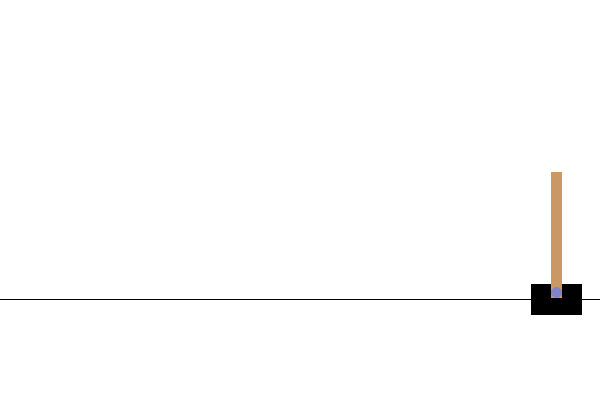

In [14]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(image_file)